## Final Project Submission

Please fill out:
* Student name: Jessica Forrest-Baldini
* Student pace: Part-time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


## Import Packages & Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as stats
from datetime import datetime as date
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('kc_house_data.csv') 
df = pd.DataFrame(data)

## Clean Data

In [2]:
# Drop waterfront - only 146 homes with waterfronts
# Drop view - this represent if the property has been viewed
# Drop id

to_drop = ['waterfront','view','id']
df = df.drop(to_drop, axis=1)

In [3]:
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

In [4]:
# Since not all homes have been renovated, I'm going to replace the 'NaN' values for 
# 'yr_renovated' with '0'
df.yr_renovated = df.yr_renovated.fillna(0)
# Add 1 for log transformation later
df.yr_renovated = df.yr_renovated + 1

In [5]:
# Replace NaN basement values with 0 as there are only 454 of them 
# Test median values for these later to see if it improves model

df.sqft_basement = df.sqft_basement.replace('?','0.0').astype(float)
#df.sqft_basement = df.sqft_basement+1

In [6]:
# Take abs of longitude for normalization later on
df.long = abs(df.long)

In [7]:
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0,21597.0
mean,540297.0,3.0,2.0,2080.0,15099.0,1.0,3.0,8.0,1789.0,286.0,1971.0,70.0,98078.0,48.0,122.0,1987.0,12758.0
std,367368.0,1.0,1.0,918.0,41413.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27274.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,1.0,98001.0,47.0,121.0,399.0,651.0
25%,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,1.0,98033.0,47.0,122.0,1490.0,5100.0
50%,450000.0,3.0,2.0,1910.0,7618.0,2.0,3.0,7.0,1560.0,0.0,1975.0,1.0,98065.0,48.0,122.0,1840.0,7620.0
75%,645000.0,4.0,2.0,2550.0,10685.0,2.0,4.0,8.0,2210.0,550.0,1997.0,1.0,98118.0,48.0,122.0,2360.0,10083.0
max,7700000.0,33.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2016.0,98199.0,48.0,123.0,6210.0,871200.0


We can see here that bedrooms has what seems to be a major outlier, 33 bedrooms. Let's take a deeper look. 

In [8]:
# Compare with other homes in data set that have high number of bedrooms
df[df.bedrooms > 9] 

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8748,8/21/2014,520000.0,11,3.00,3000,4960,2.0,3,7,2400,600.0,1918,2000.0,98106,47.5560,122.363,1420,4960
13301,8/14/2014,1150000.0,10,5.25,4590,10920,1.0,3,9,2500,2090.0,2008,1.0,98004,47.5861,122.113,2730,10400
15147,10/29/2014,650000.0,10,2.00,3610,11914,2.0,4,7,3010,600.0,1958,1.0,98006,47.5705,122.175,2040,11914
15856,6/25/2014,640000.0,33,1.75,1620,6000,1.0,5,7,1040,580.0,1947,1.0,98103,47.6878,122.331,1330,4700
19239,12/29/2014,660000.0,10,3.00,2920,3745,2.0,4,7,1860,1060.0,1913,1.0,98105,47.6635,122.320,1810,3745


In [9]:
# 33 bedrooms and only 1.75 bathrooms doesn't seem right. It is a pretty big lot at 6,000sqft
# but 33 bedrooms doesn't seem right. Remove. 

to_drop = df[df.bedrooms == 33].index
df = df.drop(to_drop)

In [10]:
df.describe().round()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0,21596.0
mean,540292.0,3.0,2.0,2080.0,15100.0,1.0,3.0,8.0,1789.0,286.0,1971.0,70.0,98078.0,48.0,122.0,1987.0,12759.0
std,367376.0,1.0,1.0,918.0,41414.0,1.0,1.0,1.0,828.0,440.0,29.0,364.0,54.0,0.0,0.0,685.0,27275.0
min,78000.0,1.0,0.0,370.0,520.0,1.0,1.0,3.0,370.0,0.0,1900.0,1.0,98001.0,47.0,121.0,399.0,651.0
25%,322000.0,3.0,2.0,1430.0,5040.0,1.0,3.0,7.0,1190.0,0.0,1951.0,1.0,98033.0,47.0,122.0,1490.0,5100.0
50%,450000.0,3.0,2.0,1910.0,7619.0,2.0,3.0,7.0,1560.0,0.0,1975.0,1.0,98065.0,48.0,122.0,1840.0,7620.0
75%,645000.0,4.0,2.0,2550.0,10686.0,2.0,4.0,8.0,2210.0,550.0,1997.0,1.0,98118.0,48.0,122.0,2360.0,10083.0
max,7700000.0,11.0,8.0,13540.0,1651359.0,4.0,5.0,13.0,9410.0,4820.0,2015.0,2016.0,98199.0,48.0,123.0,6210.0,871200.0


We can see price has some big outliers as well, as the 75th percentile is \\$ 645,000 and the max is \\$ 7,700,000, which is \\$ 7M more. 

We can see that sqft_lot also has some big outliers with the 75th percentile being just 10,686 sq. ft. while the max is 1,651,359 sq. ft.

Bedrooms appears to have an outlier at 33, with the 75th percentile being just 4.

Let's take a closer look at the percentiles for each.

In [11]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.price.quantile(q=q)))

I'm going to remove the bottom and top percentile to remove outliers.

In [12]:
orig_tot = len(df)
df = df[(df.price >= 154000.0) & (df.price <= 1970000.0)] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.019864789775884423


In [13]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,3,7,1180,0.0,1955,1.0,98178,47.5112,122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,3,7,2170,400.0,1951,1992.0,98125,47.7210,122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,3,6,770,0.0,1933,1.0,98028,47.7379,122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,5,7,1050,910.0,1965,1.0,98136,47.5208,122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,3,8,1680,0.0,1987,1.0,98074,47.6168,122.045,1800,7503


In [14]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.sqft_lot.quantile(q=q)))

In [15]:
orig_tot = len(df)
df = df[(df.sqft_lot >= 1010.61) & (df.sqft_lot <= 213008.0)] # Subsetting to remove extreme outliers
print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.019842207209335286


In [16]:
# for i in range(0,100):
#     q = i/100
#     print("{} percentile: {}".format(q, df.bedrooms.quantile(q=q)))

In [17]:
# orig_tot = len(df)
# df = df[(df.bedrooms >= 2.0) & (df.bedrooms <= 6.0)] # Subsetting to remove extreme outliers
# print('Percent removed:', (orig_tot -len(df))/orig_tot)

### 'sqft_basement'

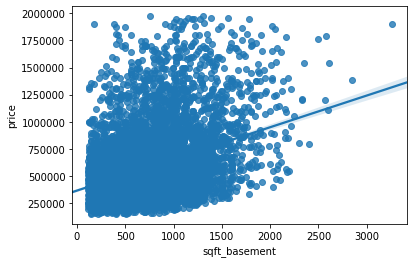

In [18]:
sns.regplot(df[df.sqft_basement >= 110].sqft_basement,df[df.sqft_basement >= 110].price);

Only 8,317 of the 32,000+ homes have basements, so we're going to bin them. I used zero as one bin and then did a quartile split for all the 'sqft_basement' values for homes with basements. 

In [19]:
# # Bin 'sqft_basement' starting at the min square footage for homes with a basement
# bins = pd.qcut(df.sqft_basement[df.sqft_basement >= 110],q=4)
# bins.value_counts()

In [20]:
# Bin sqft_basement

bins_sqft_basement = [0,109,450,980,5000]

# Bin data & return dummies
def binned_dummies(data, features, bins):
    data_bins = pd.cut(data, bins)
    data_bins = data_bins.cat.as_unordered()
    dummies = pd.get_dummies(data_bins, prefix = features, drop_first=True)
    return dummies

dummies_sqft_basement = binned_dummies(df.sqft_basement,'sqft_basement', bins_sqft_basement)

# Remove original column from data set
df = df.drop(['sqft_basement'], axis=1)
                                            
# Add new columns in
df = pd.concat([df, dummies_sqft_basement], axis=1)

In [21]:
# plt.hist(df.grade);

In [22]:
# plt.hist(df.condition);

In [23]:
# df.condition.describe()

In [24]:
# plt.hist(df.long);

In [25]:
# Define function to convert datestr to datenum
def datenum(datestr):
    '''
    Convert datestring in the format MM/DD/YYYY
    to MATLAB style datenum
    '''
    datenum = date.toordinal(date((int(datestr.split('/', -1)[2])),
                                  (int(datestr.split('/', -1)[0])),
                                  (int(datestr.split('/', -1)[1]))
                                 ))+366
    return datenum

# Apply to date column
df.date = df.date.map(datenum)

Explore the data and check for any outliers.

In [26]:
# round(df.describe(),1)

'sqft_lot' seems to have a major outlier at 1,651,359 sqft. Let's take a closer look.

In [27]:
# print(df.sqft_lot.median())
# display(df.sort_values(by='sqft_lot', ascending=False).head(5))

This appears to be the highest, but not necessarily an outlier. Let's go ahead and leave it for now. 

In [28]:
# df.long.describe()

In [29]:
# plt.hist(df.long);

## Normalize, MinMax Scale, Standardize, 
One-Hot Encode

First, check for normality, heteroscedasticity & discover categorical data. Can get a good idea of categorical features from looking at the data above, but let's explore normality, categorical and any relationships using a pairplot.

In [30]:
# Commented out because takes a long time to run
#sns.pairplot(df)

While 'condition' and 'grade' are technically categorical, they are on a scale, so I am going to leave them as is, and will min-max scale them. 

In [31]:
# Normalize Data

# Log Transform 

# Continuous variables
features = ['date','price','sqft_living','lat','long','bedrooms',
            'bathrooms','floors','condition','grade','sqft_lot',
            'sqft_above','yr_built','yr_renovated','sqft_living15',
            'sqft_lot15','zipcode']

df_cont_features = df[features]

# Add '_log' to continuous variable column names
#log_names = [f'{column}_log' for column in df_cont_features.columns]

# Log transform continuous variables
df_log = np.log(df_cont_features)
#df_log.columns = log_names


### Normalize (subract mean and divide by std)

# Define function to normalize
def normalize(feature):
    return (feature - feature.mean()) / feature.std()

# Apply function to normalize
df_log_norm = df_log.apply(normalize)

# Define function to min-max scale
def minmaxscale(feature):
    return (feature-min(feature))/(max(feature)-min(feature))

# Apply function to min-max scale
df_log_norm_scale = df_log.apply(minmaxscale)

# Remove original column from data set
df = df.drop(features, axis=1)

# Add new columns in
df = pd.concat([df, df_log_norm_scale], axis=1) 

In [32]:
# df.head()

## Check for Multicollinearity 

### Multicollinearity

In [33]:
# Take a look at the correlation matrix to check for multicollinearity
abs(df.corr()) > 0.75

,"sqft_basement_(109, 450]","sqft_basement_(450, 980]","sqft_basement_(980, 5000]",date,price,sqft_living,lat,long,bedrooms,bathrooms,floors,condition,grade,sqft_lot,sqft_above,yr_built,yr_renovated,sqft_living15,sqft_lot15,zipcode
"sqft_basement_(109, 450]",True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(450, 980]",False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
"sqft_basement_(980, 5000]",False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
date,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
price,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False
lat,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
long,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
bedrooms,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False


In [34]:
# # Check & see if sqft_lot15 & sqft_living15 are correlated with sqft_lot & sqft_living
# sns.regplot(df.sqft_lot,df.sqft_lot15)
# plt.show()
# sns.regplot(df.sqft_living,df.sqft_living15)
# plt.show()

We can see that 'sqft_lot15' & 'sqft_living15' are correlated with 'sqft_lot' & 'sqft_living', which makes sense because the features appended with 15 represent the average of the 15 nearest neighbors. 

We will remove these values to prevent multicollinearity in our model. 

In [35]:
# # Remove sqft_lot15 & sqft_living15
# df = df.drop(['sqft_lot15','sqft_living15'], axis=1)

In [36]:
# # Take a look at the correlation matrix to check for multicollinearity
# df.corr() > 0.75

We can see here that 'sqft_living' seems to be highly correlated with multiple features such as 'bathrooms', 'grade', and 'sqft_above'. 'sqft_living' represents the square footage of the entire home and seems that it would be a strong indicator of home price. The squarefoot of other features are essentially subsets of the overall home squarefootage. So for now I am going to remove it. However, it could be kept in place and other features removed later on to see if this improves the overall performance of the model.

In [37]:
# # Remove 'sqft_living' to prevent multicollinearity 
# # as it is highly correlated with multiple features

# df = df.drop(['sqft_living'], axis=1)

In [38]:
# abs(df.corr()) > 0.75

It looks like 'sqft_above' and 'grade' are highly correlated, so we should only keep one to prevent multicollinearity. 

For now I'm going to keep 'sqft_above', but can also test removing 'sqft_above' and one-hot-encoding 'grade' later on to see if it improves performance of the model. 

In [39]:
# # We can see the relationship here between 'sqft_above' and 'grade', it appears to possibly
# # be polynomial. While grade is categorical, it is continuous
# sns.regplot(df.grade,df.sqft_above);

Since the relationship looks slightly polynomial, and 'grade' technically is categorical, I want to look at their distributions to further explore the relationship. Let's look at the histograms/distplot.

In [40]:
# sns.distplot(df.sqft_above)
# plt.show()
# plt.hist(df.grade)
# plt.show()

Both do appear to be skewed in the same direction, so perhaps they are linearly related. Okay, I will remove grade. 

In [41]:
# df = df.drop(['grade'], axis=1)

In [42]:
# df.head()

### Separate Target & Feature Variables

In [43]:
# Separate target and feature variables

X = df.drop(['price'],axis=1)
y = df.price

# Start Modeling

## First with Scikit Learn

In [44]:
# Import train_test_split from sklearn
from sklearn.model_selection import train_test_split

# Split data with test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [45]:
# Fit Model & Calculate Predictions

# Import Packages
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Initialize the linear regression model class
linreg = LinearRegression()

# Fit the model to train data
linreg.fit(X_train, y_train)

# Calculate predictions on test set
y_hat_test = linreg.predict(X_test)

# Calculate RMSE of test set
test_mse = mean_squared_error(y_test, y_hat_test)

# Assign coefficients & intercept
intercept=linreg.intercept_
coefficients=linreg.coef_

# Output y-int, coeffs & RMSE of the test set
print(f"y-int: {intercept}")
print(f"coeffs: {coefficients}")
print(f"MSE test: {test_mse}")

y-int: -0.6094406224126786
coeffs: [ 0.03091309  0.02663161  0.05290547  0.02825388  0.22245864  0.32308978
  0.05392669 -0.12767428  0.08655964  0.04560289  0.12053232  0.69535652
  0.01162623  0.19748933 -0.17945342  0.03607691  0.29874797 -0.08154502
 -0.03496321]
MSE test: 0.009698217951695176


### Cross-validate Model

In [46]:
# Cross-validate & Output RMSE & R^2 

# Import Packages
from sklearn.model_selection import cross_val_score

# Cross-validate Model

# Test Errors
mse = make_scorer(mean_squared_error)
cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
print(f"Crossval MSE: {cv_5_results.mean()}")

# R-squared
from sklearn.model_selection import KFold
crossval = KFold(n_splits=10, shuffle=True, random_state=1)
baseline_R2 = np.mean(cross_val_score(linreg, X, y, scoring='r2', cv=crossval))
print(f"Baseline R^2: {baseline_R2}")

Crossval MSE: 0.009563416330911848
Baseline R^2: 0.7375618238071143


## Now with OLS

### Model 1: All Features w/o Interactions

In [47]:
# Fit Model & Output Regression Results Summary

# Import Package
import statsmodels.api as sm
from statsmodels.api import add_constant

# Build Model
X = sm.add_constant(X)
model1 = sm.OLS(y,X)
results1 = model1.fit()

# MSE of the residuals
print(f"MSE: {results1.mse_resid}")

# Output Results
results1.summary()

MSE: 0.009474754194942816


/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.739
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     3083.
Date:                Wed, 13 May 2020   Prob (F-statistic):               0.00
Time:                        23:34:47   Log-Likelihood:                 18903.
No. Observations:               20747   AIC:                        -3.777e+04
Df Residuals:                   20727   BIC:                        -3.761e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -0.6067      0.011    -56.478      0.000      -0.628      -0.586
sqft_basement_(109, 450]      0.0313      0.003     10.419      0.000       0.025       0.037
sqft_basement_(450, 980]      0.0298      0.004      7.551      0.000       0.022       0.038
sqft_basement_(980, 5000]     0.0551      0.005     10.152      0.000       0.044       0.066
date                          0.0290      0.002     12.364      0.000       0.024       0.034
sqft_living                   0.2041      0.028      7.260      0.000       0.149       0.259
lat                           0.3226      0.003     97.859      0.000       0.316       0.329
long                          0.0450      0.008      5.658      0.000       0.029       0.061
bedrooms                     -0.1246      0.008    -15.845      0.000      -0.140      -0.109
bathrooms                     0.0884      0.009     10.241      0.000       0.071       0.105
floors                        0.0452      0.004     11.744      0.000       0.038       0.053
condition                     0.1283      0.007     19.028      0.000       0.115       0.142
grade                         0.7013      0.012     58.523      0.000       0.678       0.725
sqft_lot                      0.0076      0.011      0.666      0.505      -0.015       0.030
sqft_above                    0.2170      0.026      8.373      0.000       0.166       0.268
yr_built                     -0.1815      0.004    -43.957      0.000      -0.190      -0.173
yr_renovated                  0.0346      0.004      8.768      0.000       0.027       0.042
sqft_living15                 0.2864      0.009     30.612      0.000       0.268       0.305
sqft_lot15                   -0.0792      0.015     -5.412      0.000      -0.108      -0.051
zipcode                      -0.0333      0.003    -10.329      0.000      -0.040      -0.027
==============================================================================
Omnibus:                      508.112   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              841.461
Skew:                           0.228   Prob(JB):                    1.90e-183
Kurtosis:                       3.875   Cond. No.                         131.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can see here that 'sqft_lot' is no longer significant. We can remove that, but first let's take a look at the residuals and the coefficients.

### Q-Q Plot of the Model Residuals

Test for normality assumption.

In [48]:
# Q-Q Plot

# Define function 
def qqplot(results):
    '''
    Takes in OLS Regression Results and outputs q-q plot 
    of the model residuals.
    '''
    fig = sm.graphics.qqplot(results.resid, dist=stats.norm, line='45', fit=True)
    return plt.show()

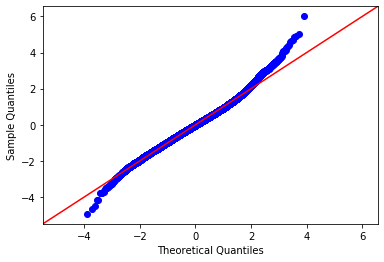

In [49]:
qqplot(results1)

Looks good. We previously removed extreme outliers during the cleaning of the data. There may still be some, but in order to preserve as much of the data as possible, this looks pretty good and we can leave it as is (not remove more outliers).

In [50]:
# Define function to output plot of the model coefficients

def coefplot(results):
    '''
    Takes in results of OLS model and returns a plot of 
    the coefficients with 95% confidence intervals.
    '''
    # Create dataframe of results summary 
    coef_df = pd.DataFrame(results.summary().tables[1].data)
    
    # Add column names
    coef_df.columns = coef_df.iloc[0]

    # Drop the extra row with column labels
    coef_df=coef_df.drop(0)

    # Set index to variable names 
    coef_df = coef_df.set_index(coef_df.columns[0])

    # Change datatype from object to float
    coef_df = coef_df.astype(float)

    # Get errors; (coef - lower bound of conf interval)
    errors = coef_df['coef'] - coef_df['[0.025']
    
    # Append errors column to dataframe
    coef_df['errors'] = errors

    # Drop the constant for plotting
    coef_df = coef_df.drop(['const'])

    # Sort values by coef ascending
    coef_df = coef_df.sort_values(by=['coef'])

    ### Plot Coefficients ###

    # x-labels
    variables = list(coef_df.index.values)
    
    # Add variables column to dataframe
    coef_df['variables'] = variables

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(15, 10))
    coef_df.plot(x='variables', y='coef', kind='bar',
                 ax=ax, color='none', fontsize=18, 
                 ecolor='black',capsize=7,
                 yerr='errors', legend=False)
    plt.title('')
    ax.set_ylabel('Coefficients',fontsize=18)
    ax.set_xlabel('Features',fontsize=18)
    ax.scatter(x=pd.np.arange(coef_df.shape[0]), 
               marker='s', s=40, 
               y=coef_df['coef'], color='black')
    ax.axhline(y=0, linestyle='--', color='red', linewidth=1);
    return plt.show()

Let's check out the residuals. I'm excited to see which coefficients have the greatest effect on the price of a house. (The highest coefficient that is.)

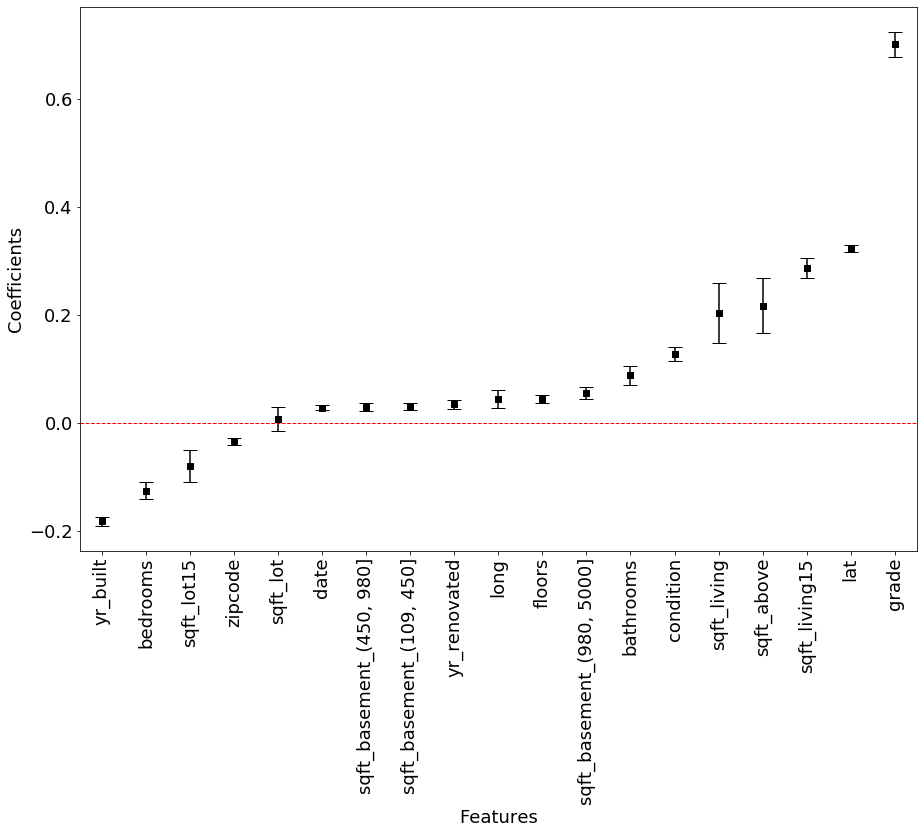

In [51]:
# Plot coefficients w/95% confidence intervals for Model 1
coefplot(results1)

No big suprise here. As we guessed earlier, it appears to be grade. This makes sense as higher grade is more of a luxury home and we could see the relationship appeared to be slightly exponential. 

We could add this as a polynomial feature instead and see how the model does, but our R^2 looks pretty good and we are able to interpret results. If need be we can always revisit later. For now let's keep moving along.

Next we'll take a look at the interactions between our feature variables to see if there are any interactions going on that better predict price than the features alone.

### Interactions

In [ ]:
# Import package we'll be using
from itertools import combinations

# Find top interactions using R^2 value

# Use combinations from itertools to create all possible combinations of two features
feat_combinations = combinations(X_train.columns, 2)

# Initiate empty list to fill for interactons values
interactions = []

# for i, (feature1,feature2) in feature_combinations:
for i, (a, b) in enumerate(feat_combinations):
    # fill interatctions list with feature a * feature b
    X_train['interaction'] = X_train[a] * X_train[b]
    R2 = np.mean(cross_val_score(linreg, X_train, y_train, scoring='r2', cv=crossval))
    if R2 > baseline_R2:
        interactions.append((a, b, round(R2,5)))

# Print out the top 5 interactions
print('Top 5 interactions: %s' %sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5])

We can see here that the top 3 interactions are all between sqft_living, grade, and bathrooms. This is affirming as we could see in our EDA that these three each had apparent relationships with price.

"Top 3 interactions: [('sqft_living_log', 'grade_log', 0.74664), ('bathrooms_log', 'grade_log', 0.7455), ('sqft_living_log', 'bathrooms_log', 0.74479)]". Each time we run this model, sometimes the 3rd one switches, but this is the one that outputs the most, so we're going to go ahead with these three.

Let's add these interactions into our model one at a time to see how they affect the R^2 and MSE values of our model.

### Model 1: All Features w/Top 3 Interactions

In [ ]:
X

In [ ]:
#Build a final model with interactions
final = X.copy()

final['sqft_living*grade'] = final['sqft_living'] * final['grade']
final['bathrooms*grade'] = final['bathrooms'] * final['grade']
final['sqft_living*bathrooms'] = final['sqft_living'] * final['bathrooms']

In [ ]:
# Build Model

final = sm.add_constant(final)
model = sm.OLS(y,final)
results2a = model.fit()

# MSE of the residuals
print(f"MSE: {results2a.mse_resid}")

results2a.summary()

We can see that sqft_lot is no longer significant. Let's go ahead and remove it and see how it affects our model.

In [ ]:
final = final.drop(['sqft_lot'], axis=1)

In [ ]:
# Build Model

final = sm.add_constant(final)
model = sm.OLS(y,final)
results2b = model.fit()

# MSE of the residuals
print(f"MSE: {results2b.mse_resid}")

results2b.summary()

In [ ]:
# Plot q-q for Model 2 residuals
qqplot(results2b)

In [ ]:
# Plot coefficients w/95% confidence intervals for Model 2
coefplot(results2b)

### Model 3: All Features w/Top 5 Interactions

Since the top 5 interactions were all so close to each other in R^2 values, I'm curious to see how the Model performs with all 5, and if we can gain any additional insights with the resulting coefficients.

In [ ]:
# Add 4th & 5th ranked interactions
final['sqft_living*sqft_above'] = final['sqft_living'] * final['sqft_above']
final['grade*sqft_above'] = final['grade'] * final['sqft_above']

In [ ]:
# Build Model 3

final_const = sm.add_constant(final.values)
model = sm.OLS(y,final_const)
results3 = model.fit()

# MSE of the residuals
print(f"MSE: {results3.mse_resid}")

results3.summary()

In [ ]:
# Plot q-q for Model 3 residuals
qqplot(results3)

# Plot coefficients w/95% confidence intervals for Model 3
coefplot(results3)